# 1. Home Credit Default Risk Competition

Kaggle link : https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction

## Loading Packages and Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures

# modeling
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

sns.set_style('darkgrid')

In [2]:
# train data
app_train = pd.read_csv('data/application_train.csv')
print('Training Data Shape:', app_train.shape)
app_train.head()

Training Data Shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [3]:
# test data
app_test = pd.read_csv('data/application_test.csv')
print('Test Data Shape: ',app_test.shape)
app_test.head()

Test Data Shape:  (48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [4]:
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

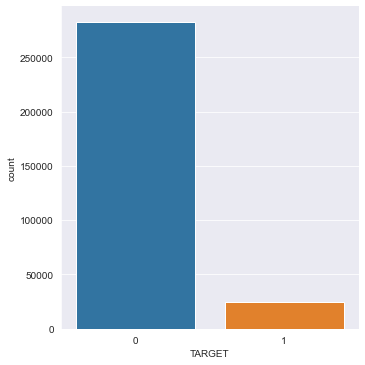

In [5]:
sns.catplot(x = 'TARGET', data = app_train, kind = 'count')

Target 값이 0 (will repay loan on time) ,1 (Will have difficulty repaying loan)로 이루어져있으며, 불균형적인 분포를 띈다. 

### Examine Missing Value

In [6]:
def missing_values_table(df):
    # 결측치 총합
    mis_val = df.isnull().sum()
    
    # Percentage
    mis_val_percent = 100 * (df.isnull().sum() / len(df))
    
    # 보기 쉽게 Table 형태로 만듦
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis = 1)
    
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[mis_val_table_ren_columns.iloc[:, 1] != 0].sort_values('% of Total Values', ascending = False).round(1)
    
    # 출력
    print('Your selected Dataframe has ' + str(df.shape[1]) + ' columns.\n'  'There are ' + str(mis_val_table_ren_columns.shape[0]) + 'columns that have missing values')
    
    return mis_val_table_ren_columns

In [7]:
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected Dataframe has 122 columns.
There are 67columns that have missing values


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


예측모델을 구축할 때, 우리들은 Missing value들을 적절한 방법들을 통해 채워줘야 한다. 

이번 분석에는 결측치 대체를 안 해도 되는 XGBoost 모델을 사용할 것이다.

다른 방법은 예측에 도움이 되지 않고, 결측치 비율도 높은 column을 삭제하는 방법도 있다.

<b> Columns Type

In [8]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [9]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

대부분의 categorical 변수들은 적은 수의 unique한 값을 갖는다.

### Encoding Categorical Variable

Encoding 관련해서 올렸던 스터디가 도움이 되었다.

https://github.com/junghosub/Bigtato-Study/blob/main/Week%203%20-%20Encoding.ipynb

결론적으로 unique <= 2라면 Label Encoding을 택하고, unique > 2라면 One-Hot Encoding 방법을 채택했다.

In [10]:
# Label Encoding
le = LabelEncoder()
le_count = 0

for col in app_train:
    if app_train[col].dtype == 'object':
        # unique <= 2
        if len(list(app_train[col].unique())) <= 2:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            le_count += 1
    
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [11]:
# One-Hot Encoding
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features Shape: ', app_train.shape)
print('Test Features Shape: ', app_test.shape)

Training Features Shape:  (307511, 243)
Test Features Shape:  (48744, 239)


In [12]:
train_labels = app_train['TARGET']

app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

app_train['TARGET'] = train_labels

print('Training Features Shape: ', app_train.shape)
print('Test Features Shape: ', app_test.shape)

Training Features Shape:  (307511, 240)
Test Features Shape:  (48744, 239)


## Back to the EDA

### Anomailes

In [13]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [14]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

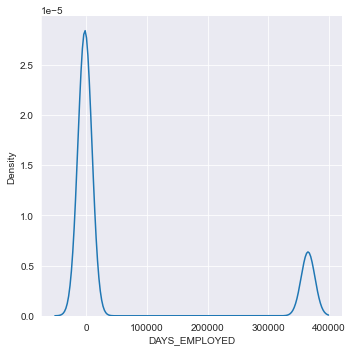

In [15]:
sns.displot(x = 'DAYS_EMPLOYED', data = app_train, kind = 'kde')

In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on {} of loans'.format(round(100 * non_anom['TARGET'].mean(),2)))
print('The anomalies default on {} of loans'.format(round(100 * anom['TARGET'].mean(),2)))
print('The non-anomalies default on {} of loans'.format(len(anom)))

The non-anomalies default on 8.66 of loans
The anomalies default on 5.4 of loans
The non-anomalies default on 55374 of loans


흥미롭게도 DAYS_EMPLYED가 이상치일 때와 아닐 때 차이가 존재한다! 이를 이용하도록 한다.

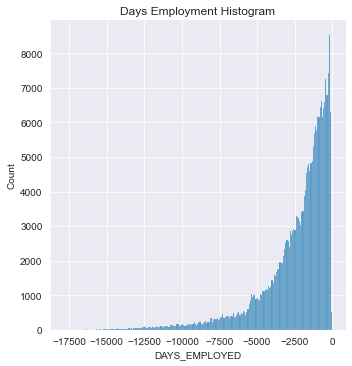

In [17]:
# 새로운 변수 생성
app_train['DAYS_EMPLOYED_ANOM'] = app_train['DAYS_EMPLOYED'] == 365243

# 대체
app_train['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace = True)

sns.displot(x = 'DAYS_EMPLOYED', data = app_train, fill = True)
plt.title('Days Employment Histogram')
plt.show()

In [18]:
# test 데이터에도 동일하게 적용
app_test['DAYS_EMPLOYED_ANOM'] = app_test['DAYS_EMPLOYED'] == 365243
app_test['DAYS_EMPLOYED'].replace({365243 : np.nan}, inplace = True)

print('There are %d anomalies in the test data out of  %d entries ' % (app_test['DAYS_EMPLOYED_ANOM'].sum(), len(app_test)))

There are 9274 anomalies in the test data out of  48744 entries 


### Correlations

<b> 일반적인 상관계수의 해석 </b>
- .00 ~ 0.19 매우 약함
- .20 ~ .39 약함
- .40 ~ .59 중간
- .60 ~ .79 강함
- .80 ~ 1.0 매우 강함
(절댓값을 기준으로 한 것임)

In [19]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations : \n', correlations.tail(15))
print('\n Most Negative Correlations \n:',correlations.head(15))

Most Positive Correlations : 
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

 Most Neg

상관계수가 가장 높은 변수는 DAYS_BIRTH이다. 앞서 확인했듯 DAYS_BIRTH는 음수의 값을 가지고 있다. 조금 헷갈리니 절댓값을 취해 쉽게 이해할 수 있도록 처리해준다.

<b> DAYS_BRITH

In [20]:
# DAYS_BIRTH
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982712

절댓값을 취해준 후, 상관계수를 구해보니 약 -0.078이 나왔다. 

이 말은 고객이 나이가 들수록 대출을 제때 상환한다고 볼 수 있다. 

반대로 고객의 나이가 젊을수록 체납을 한다고 볼 수 있다.

Text(0.5, 0, 'Age')

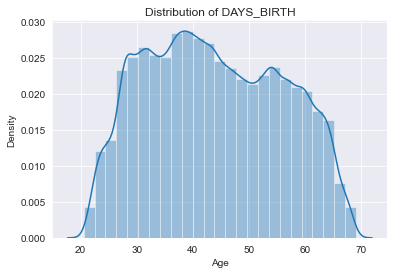

In [21]:
sns.distplot(x = app_train['DAYS_BIRTH'] / 365, bins=25, kde = 'histogram')
plt.title('Distribution of DAYS_BIRTH', size = 12)
plt.xlabel('Age')

히스토그램을 통해 보았을 때, 특별한 이상치가 존재하지 않는 것으로 보인다.

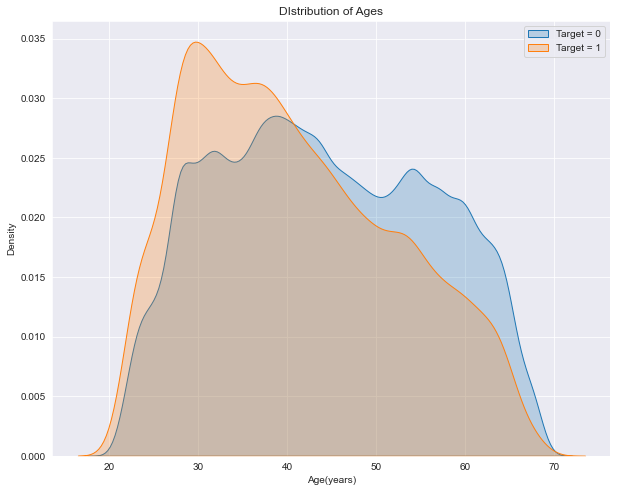

In [22]:
plt.figure(figsize = (10,8))

sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'Target = 0', fill = True)
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'Target = 1', fill = True)
plt.title('DIstribution of Ages', size = 12)
plt.xlabel('Age(years)')
plt.ylabel('Density')
plt.legend()

target = 1인 분포를 보면 상대적으로 젊은 층의 연령이 두드러진다. 비록 상관계수가 매우 낮지만 모델링을 할 땐, 매우 유용할 것으로 판단된다.

In [23]:
#  years_birht 변수 생성
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Binning 구간화
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20,70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [24]:
# Groupby 
age_groups = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


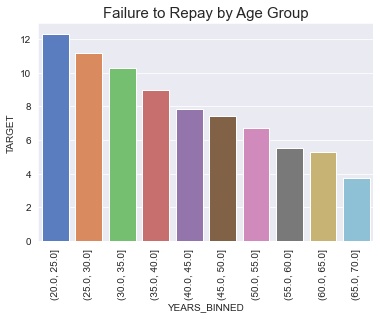

In [25]:
sns.barplot(x = age_groups.index, y = 100 * age_groups['TARGET'], data = age_groups, palette = 'muted')
plt.title('Failure to Repay by Age Group', size = 15)
plt.xticks(rotation = 90)
plt.show()

<b> Exterior Sources

Text(0.5, 1.0, 'Correation Heatmap')

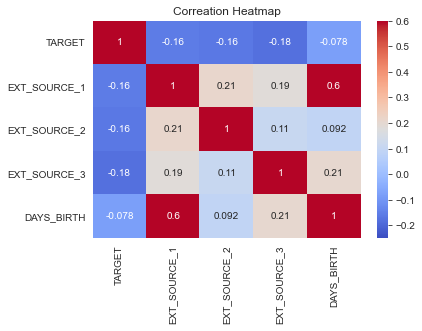

In [26]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()

sns.heatmap(ext_data_corrs, cmap = 'coolwarm', vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correation Heatmap')

모든 EXT_SOURCE는 Target과 음의 상관관계를 가지고 있다. 이 말은 EXT_SOURCE가 증가할수록, 고객들은 대출을 제때 갚는다는 말이다. 

또한 Days_Birth와 EXT_SOURCE가 강한 양의 상관관계를 가지고 있다는 것을 볼 수 있다. EXT_SOURCE_1은 연령과 관계있는 변수일 수도 있다.

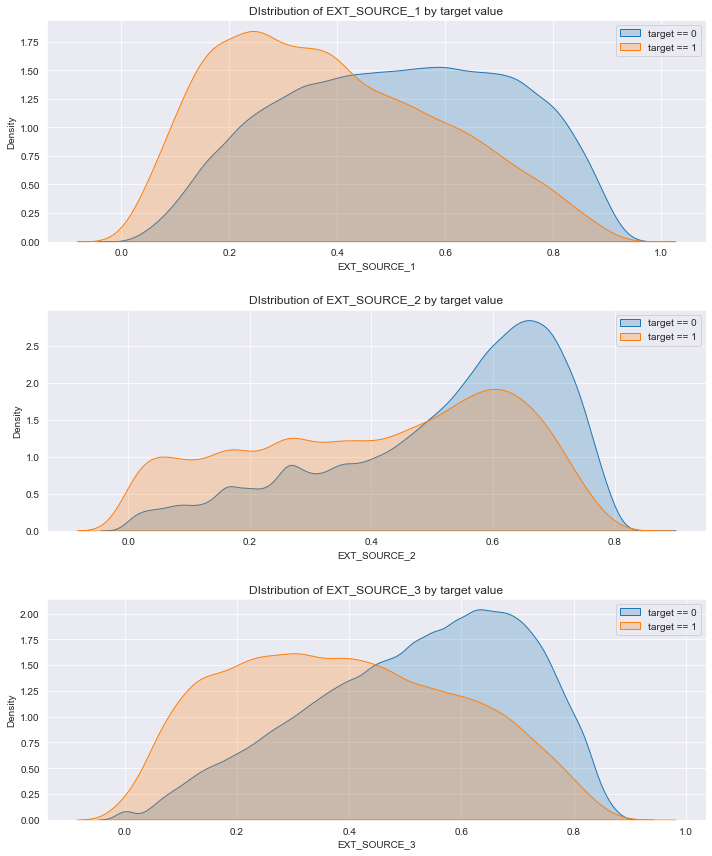

In [27]:
plt.figure(figsize = (10,12))

for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
        plt.subplot(3, 1, i + 1)
        sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0', fill = True)
        sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1', fill = True)
        plt.title('DIstribution of %s by target value' % source)
        plt.xlabel('%s' % source)
        plt.ylabel('Density')
        plt.legend()
plt.tight_layout(h_pad = 2.5)

EXT_SOURCE_3가 가장 많은 차이를 보인다. 이는 모델링을 하는데 유용할 것으로 보인다.

### Pair Plot

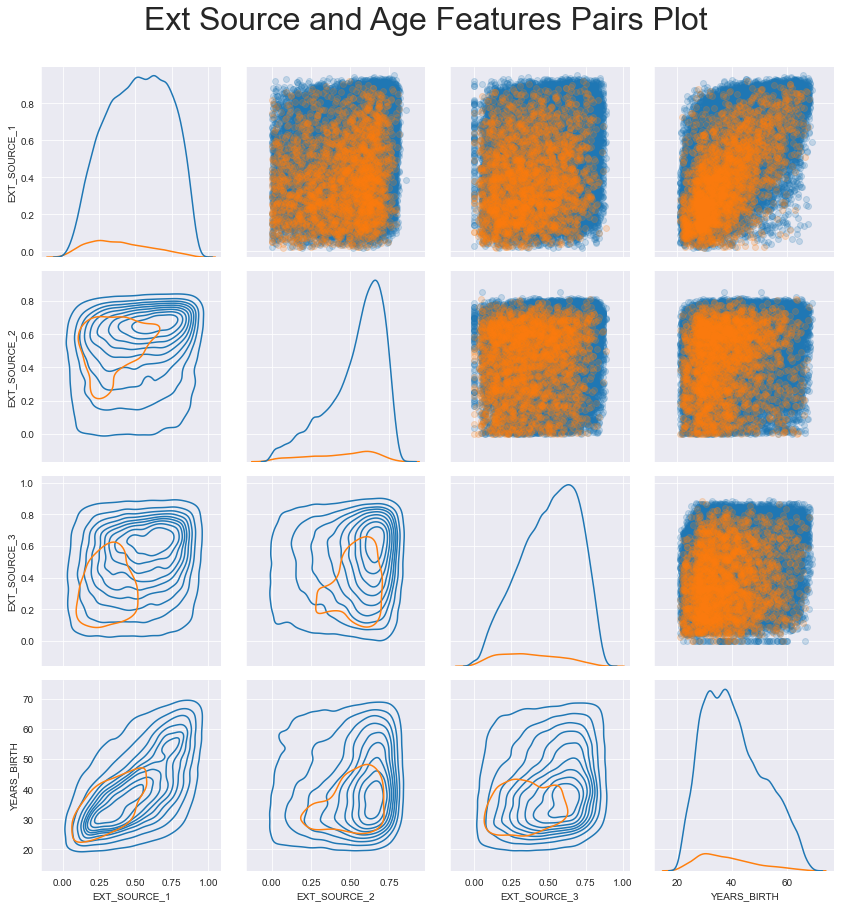

In [28]:
plot_data = ext_data.drop(columns = ['DAYS_BIRTH']).copy()
plot_data['YEARS_BIRTH'] = age_data['YEARS_BIRTH']

plot_data = plot_data.dropna().loc[:100000, :]

def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)
grid = sns.PairGrid(data = plot_data, size = 3, diag_sharey=False,
                    hue = 'TARGET', 
                    vars = [x for x in list(plot_data.columns) if x != 'TARGET'])

grid.map_upper(plt.scatter, alpha = 0.2)
grid.map_diag(sns.kdeplot)
grid.map_lower(sns.kdeplot, cmap = plt.cm.OrRd_r);

plt.suptitle('Ext Source and Age Features Pairs Plot', size = 32, y = 1.05);

## Feature Engineering

### Polynomial Features

In [29]:
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

imputer = SimpleImputer(strategy='median')

poly_target = poly_features['TARGET']
poly_features = poly_features.drop('TARGET', axis = 1)

poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.fit_transform(poly_features_test)

poly_transformer = PolynomialFeatures(degree = 3)

In [30]:
poly_transformer.fit(poly_features)

poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)

print('Polynomial Features Shape :', poly_features.shape)

Polynomial Features Shape : (307511, 35)


In [31]:
poly_transformer.get_feature_names(input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH'])[:15]

['1',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'EXT_SOURCE_2^2',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'DAYS_BIRTH^2']

In [32]:
poly_features = pd.DataFrame(poly_features, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1' ,'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['TARGET'] = poly_target

poly_corrs = poly_features.corr()['TARGET'].sort_values()

poly_corrs
#print(poly_corrs.head(10))
#print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH     -0.155891
EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH     -0.151816
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
EXT_SOURCE_3 DAYS_BIRTH                  -0.150109
EXT_SOURCE_2^2                           -0.149512
EXT_SOURCE_2^2 DAYS_BIRTH                -0.149313
EXT_SOURCE_3^2 DAYS_BIRTH                -0.141777
EXT_SOURCE_3^2                           -0.141662
EXT_SOURCE_2^3                 

In [33]:
poly_features_test = pd.DataFrame(poly_features_test, columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']))

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Test data with polynomial features shape: ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Test data with polynomial features shape:  (48744, 275)


### Domain Knowledge Features

- CREDIT_INCOME_PERCENT : the percentage of the credit amount relative to a client's income
- ANNUITY_INCOME_PERCENT : the percentage of the loan annuity relative to a client's income
- CREIDT_TERM : the length of the payment in months(since the annuity is the monthly amount due)
- DAYS_EMPLOYED_PERCENT : the percentage of the days employed relative to the cliient's age

In [34]:
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

# train
app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

# test
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

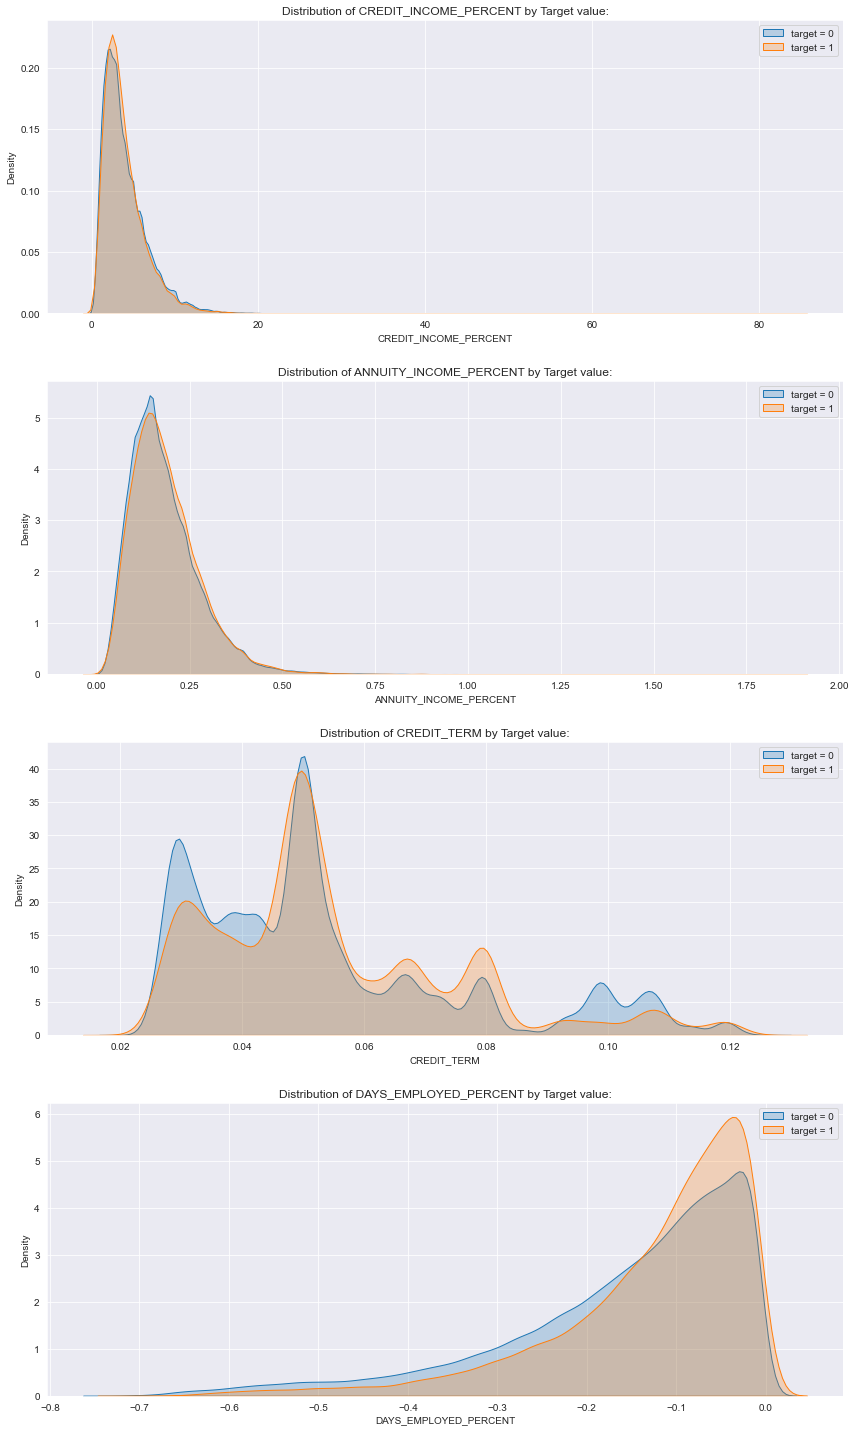

In [35]:
plt.figure(figsize = (12,20))

for i, feature in enumerate(['CREDIT_INCOME_PERCENT', 'ANNUITY_INCOME_PERCENT', 'CREDIT_TERM', 'DAYS_EMPLOYED_PERCENT']):
    plt.subplot(4, 1, i+1)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 0, feature], label = 'target = 0', fill = True)
    sns.kdeplot(app_train_domain.loc[app_train_domain['TARGET'] == 1, feature] , label = 'target = 1', fill = True)
    plt.title('Distribution of %s by Target value:' % feature)
    plt.xlabel('%s' % feature)
    plt.ylabel('Density')
    plt.legend()
plt.tight_layout(h_pad=2.5)

새로 만들어낸 변수들이 유용하진 않는 것 같다.

## Modeling

In [36]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, test_features, encoding = 'ohe', n_folds = 5):
    
    """Train and test a light gradient boosting model using
    cross validation. 
    
    Parameters
    --------
        features (pd.DataFrame): 
            dataframe of training features to use 
            for training a model. Must include the TARGET column.
        test_features (pd.DataFrame): 
            dataframe of testing features to use
            for making predictions with the model. 
        encoding (str, default = 'ohe'): 
            method for encoding categorical variables. Either 'ohe' for one-hot encoding or 'le' for integer label encoding
            n_folds (int, default = 5): number of folds to use for cross validation
        
    Return
    --------
        submission (pd.DataFrame): 
            dataframe with `SK_ID_CURR` and `TARGET` probabilities
            predicted by the model.
        feature_importances (pd.DataFrame): 
            dataframe with the feature importances from the model.
        valid_metrics (pd.DataFrame): 
            dataframe with training and validation metrics (ROC AUC) for each fold and overall.
        
    """
    
    # Extract the ids
    train_ids = features['SK_ID_CURR']
    test_ids = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = features['TARGET']
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR', 'TARGET'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
    
    # One Hot Encoding
    if encoding == 'ohe':
        features = pd.get_dummies(features)
        test_features = pd.get_dummies(test_features)
        
        # Align the dataframes by the columns
        features, test_features = features.align(test_features, join = 'inner', axis = 1)
        
        # No categorical indices to record
        cat_indices = 'auto'
    
    # Integer label encoding
    elif encoding == 'le':
        
        # Create a label encoder
        label_encoder = LabelEncoder()
        
        # List for storing categorical indices
        cat_indices = []
        
        # Iterate through each column
        for i, col in enumerate(features):
            if features[col].dtype == 'object':
                # Map the categorical features to integers
                features[col] = label_encoder.fit_transform(np.array(features[col].astype(str)).reshape((-1,)))
                test_features[col] = label_encoder.transform(np.array(test_features[col].astype(str)).reshape((-1,)))

                # Record the categorical indices
                cat_indices.append(i)
    
    # Catch error if label encoding scheme is not valid
    else:
        raise ValueError("Encoding must be either 'ohe' or 'le'")
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'], categorical_feature = cat_indices,
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [37]:
submission, fi, metrics = model(app_train, app_test)
print('Baseline metrics')
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798723	train's binary_logloss: 0.547797	valid's auc: 0.755039	valid's binary_logloss: 0.563266
[400]	train's auc: 0.82838	train's binary_logloss: 0.518334	valid's auc: 0.755107	valid's binary_logloss: 0.545575
Early stopping, best iteration is:
[315]	train's auc: 0.816657	train's binary_logloss: 0.530116	valid's auc: 0.755215	valid's binary_logloss: 0.552627
Training until validation scores don't improve for 100 rounds
[200]	train's auc: 0.798409	train's binary_logloss: 0.548179	valid's auc: 0.758332	valid's binary_logloss: 0.563587
[400]	train's auc: 0.828244	train's binary_logloss: 0.518308	valid's auc: 0.758563	valid's binary_logloss: 0.545588
Early stopping, best iteration is:
[317]	train's auc: 0.8169	train's binary_logloss: 0.529878	valid's auc: 0.758754	valid's binary_logloss: 0.552413
Training until validation scores don't impr

In [38]:
submission.to_csv('lgb_04_27.csv', index = False)